## Read TerraSAR-X Geotiff images

### Import packages

In [17]:
! activate ArcCI
print("PLEASE CHECK YOUR ENVIRONMENT is ArcCI")
import rasterio
from rasterio.plot import show
import glob, os, sys
import matplotlib.pyplot as plt
from osgeo import gdal
import numpy as np
from scipy.fft import fft, ifft
import xarray as xr
import pandas as pd
import math
import datetime as dt
import netCDF4
import cv2
import geopandas

import pandas as pd
from shapely.geometry import Point, mapping
from fiona import collection
# import arcpy
# import geopandas
# from osgeo import gdal,ogr
# fp = r'GeoTiff_Image.tif'
# img = rasterio.open(fp)
# show(img)

PLEASE CHECK YOUR ENVIRONMENT is ArcCI
(myenv) C:\Users\pbd064\TerraSAR-X>conda.bat activate ArcCI 



(18920, 13125)


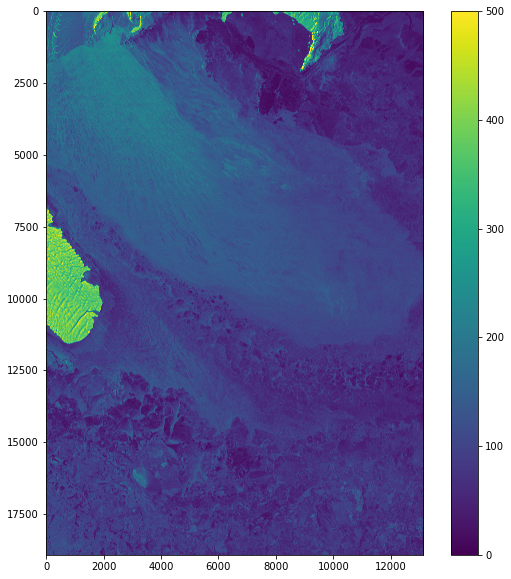

In [24]:
# fig, ax = plt.subplots(1,1, figsize = (10, 2.5), dpi = 100)
path = r"F:\TNB_TerraSARX\PIPERS_03\TDX1_SAR__MGD_RE___SC_S_SRA_20170505T094149_20170505T094211"
file = glob.glob(path + "/IMAGEDATA/*.tif")[0]
img = rasterio.open(file)
fig = plt.figure(figsize=(10, 10))
# show(img)
array = img.read(1)
plt.imshow(array)
plt.colorbar()
plt.clim(0, 500)
print(np.shape(array))

# read xml file
import xml.etree.ElementTree as ET
xmlfile = glob.glob(path + "/*.xml")[0]
tree = ET.parse(xmlfile)
root = tree.getroot()
heading = float(root.findall('productInfo/sceneInfo/headingAngle')[0].text)
mode = root.findall('productInfo/missionInfo/orbitDirection')[0].text
cellsize = float(root.findall('productInfo/imageDataInfo/imageRaster/rowSpacing')[0].text)
time_img = root.findall('productInfo/sceneInfo/start/timeUTC')[0].text[:19]
time_img = dt.datetime.strptime(time_img,"%Y-%m-%dT%H:%M:%S")

(18937, 13092)


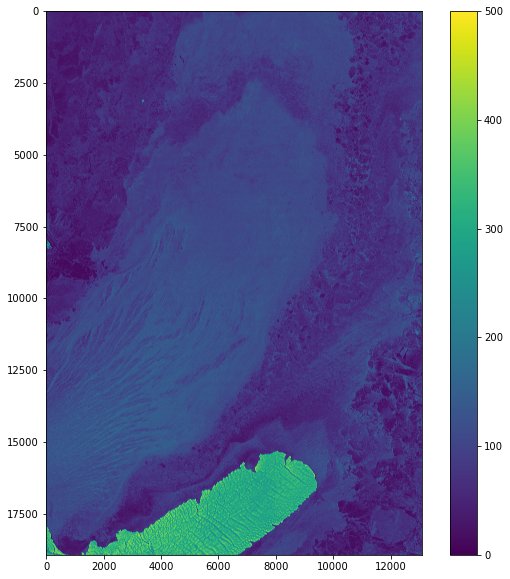

In [13]:
path = r"F:\TNB_TerraSARX\PIPERS_03\TDX1_SAR__MGD_RE___SC_S_SRA_20170505T155530_20170505T155552"
file = glob.glob(path + "/IMAGEDATA/*.tif")[0]
img = rasterio.open(file)
trsform = img.transform

fig = plt.figure(figsize=(10, 10))
# show(img)
array = img.read(1)
plt.imshow(array)
plt.colorbar()
plt.clim(0, 500)
print(np.shape(array))

# read xml file
import xml.etree.ElementTree as ET
xmlfile = glob.glob(path + "/*.xml")[0]
tree = ET.parse(xmlfile)
root = tree.getroot()
heading = float(root.findall('productInfo/sceneInfo/headingAngle')[0].text)
mode = root.findall('productInfo/missionInfo/orbitDirection')[0].text
cellsize = float(root.findall('productInfo/imageDataInfo/imageRaster/rowSpacing')[0].text)
time_img = root.findall('productInfo/sceneInfo/start/timeUTC')[0].text[:19]
time_img = dt.datetime.strptime(time_img,"%Y-%m-%dT%H:%M:%S")

In [18]:
# Fourier Transform
def draw_waveform(clipped, z, w, cellsize, d, u1, u2, imgname, threshold = 300):
    # Make figure
    fig, ax = plt.subplots(1,2,figsize = (12, 4.5), dpi = 100)
    unit = 2*np.pi / (w*cellsize)
    w_dir = 90 - math.degrees(math.atan(u2/u1)) # wave direction from north
    
    xx, yy = np.meshgrid(unit*(np.arange(0,w,1)-w/2), unit*(-np.arange(0,w,1)+w/2))
    
    ax[0].imshow(clipped, cmap = "gray")

    # plt.imshow(z, cmap='viridis')
    plt.pcolor(xx, yy, z)

    pxc = 0; pyc = 0; # plot center
    ax[1].plot([pxc, pxc-u1*d*unit], [pyc, pyc+u2*d*unit], "o-", color = "r")
    ax[1].plot([pxc, pxc+u1*d*unit], [pyc, pyc-u2*d*unit], "o-", color = "r")
    ax[1].plot([pxc-1, pxc+1], [0, 0], "o-", color = "w", linestyle = "--", linewidth = 1)
    ax[1].plot([0, 0], [pyc-1, pyc+1], "o-", color = "w", linestyle = "--", linewidth = 1)

    unit = 2*np.pi / (w*cellsize)
    circle1 = plt.Circle((pxc, pyc), w*cellsize/50*unit, color='w', fill=False) # 50 m circle
    circle2 = plt.Circle((pxc, pyc), w*cellsize/100*unit, color='w', fill=False) # 100 m circle
    circle3 = plt.Circle((pxc, pyc), w*cellsize/200*unit, color='w', fill=False) # 200 m circle
    circle4 = plt.Circle((pxc, pyc), w*cellsize/400*unit, color='w', fill=False) # 400 m circle
    ax[1].add_patch(circle1)
    ax[1].add_patch(circle2)
    ax[1].add_patch(circle3)
    ax[1].add_patch(circle4)
    
    plt.colorbar()
    plt.clim(0, threshold)

    plt.xlim(pxc-40*unit, pxc+40*unit)
    plt.ylim(pyc-40*unit, pyc+40*unit)
    plt.title(imgname)
    plt.text(-0.14, 0.13, "Wavelength=%.0f m"%(w/d * cellsize), fontsize = 12, color = "w")
    plt.text(-0.14, 0.11, "Azimuth=%.1f deg"%(w_dir), fontsize = 12, color = "w")
    
    path = r"F:\TNB_TerraSARX\FFT\Figure"
    plt.savefig(path + "/" + imgname, bbox_inches = "tight")
    plt.close()

def derive_wave(clipped, w, cellsize, imgname):
    f = np.fft.fft2(clipped)
    fshift = np.fft.fftshift(f)
    z = np.abs(fshift)

    xc = w/2
    yc = w/2
    x, y = np.meshgrid(np.arange(w), np.arange(w))
    # squared distance from the center of the circle
    d2 = (x - xc)**2 + (y - yc)**2
    # mask is True inside of the circle
    r = w*cellsize/400
    mask = d2 < r**2
    outside = np.ma.masked_where(mask, z)
    z[mask] = 0

    threshold = 300

    idx = np.where(z >= threshold)
    # plt.figure(figsize = (10, 10))
    # y[idx]

    if len(idx[0]) > 0:
        idx_x = idx[1]
        idx_y = idx[0]
        coord = []
        for i in range(0, len(idx_x)):
            coord.append([idx_x[i], idx_y[i]])

        from sklearn.decomposition import PCA
        pca = PCA(n_components=2)
        pca.fit_transform(coord)
        # print(pca.fit_transform(coord))
        # print(pca.explained_variance_)
        # # print(pca.noise_variance_)
        # print(pca.transform(coord))
        # print(coord)
    #     print(pca.components_[0])
        u1, u2 = pca.components_[0]
        
        if u1 < 0:
            u2 = -u2
            u1 = -u1

        pca1, pca2 = [], []
        for i in range(0, len(pca.transform(coord))):
            pca1.append(pca.transform(coord)[i][0])
            pca2.append(pca.transform(coord)[i][1])
        pca1 = np.array(pca1)
        pca2 = np.array(pca2)

        d = np.median(pca1[pca1 > 0])
        if u1 == 0:
            w_dir = 90
        else:
            w_dir = 90 - math.degrees(math.atan(u2/u1)) # degree from the north side
            
        w_len = w/d * cellsize
        
        if w_len < 200:
            if imgname != None:
                draw_waveform(clipped, z, w, cellsize, d, u1, u2, imgname)
            pass
#             print(u1, u2, w_dir, w_len)
        else:
            w_dir, w_len = 0, 0

    else:
#         print("WARNING: There is no wave parts!!")
        d = 0
        u1, u2 = 0, 0
        w_dir, w_len = 0, 0
    
    return w_dir, w_len, u1, u2

def derive_wave2(clipped, w, cellsize, imgname):
    # Derive wave information using max/min
    f = np.fft.fft2(clipped)
    fshift = np.fft.fftshift(f)
    z = np.abs(fshift)

    xc = w/2
    yc = w/2
    x, y = np.meshgrid(np.arange(w), np.arange(w))
    # squared distance from the center of the circle
    d2 = (x - xc)**2 + (y - yc)**2
    # mask is True inside of the circle
    r = w*cellsize/400
    mask = d2 < r**2
    outside = np.ma.masked_where(mask, z)
    z[mask] = 0
    
    threshold = 100
    
    s = 5
    kernel = np.ones((s,s))/(s**2)
    z2 = cv2.filter2D(z, -1, kernel)

    idx = np.where(z2 == np.max(z2))

    if len(idx[0]) > 0:
        idx_x = idx[1][0]
        idx_y = idx[0][0]
        
        u1 = (idx_x - np.median(np.arange(0, w)))
        u2 = (idx_y - np.median(np.arange(0, w)))
        d = (u1**2 + u2**2)**0.5
        
        u1 = u1/d
        u2 = u2/d
        
        if u1 < 0:
            u2 = -u2
            u1 = -u1

        if u1 == 0:
            w_dir = 90
        else:
            w_dir = 90 - math.degrees(math.atan(u2/u1)) # degree from the north side
            
        w_len = w/d * cellsize
        
        if w_len < 200 and np.max(z2) > threshold:
            if imgname != None:
                draw_waveform(clipped, z2, w, cellsize, d, u1, u2, imgname)
            pass
#             print(u1, u2, w_dir, w_len)
        else:
            w_dir, w_len = np.nan, np.nan

    else:
#         print("WARNING: There is no wave parts!!")
        d = np.nan
        u1, u2 = np.nan, np.nan
        w_dir, w_len = np.nan, np.nan
    
    return w_dir, w_len, u1, u2

# Rotate u1 and u2 into Northward direction
def rotate_vector(u1, u2, theta):
    # theta should be radian!!! but input is degrees!!!
    theta = theta * np.pi / 180
    u1_new = u1*np.cos(theta) - u2*np.sin(theta)
    u2_new = u1*np.sin(theta) + u2*np.cos(theta)
    return u1_new, u2_new

def convertshp(df, outfile):  

    df=df.reset_index(drop=True)

    if len(df) > 0:
        df['geometry'] = df.apply(lambda x: Point((float(x.lon), float(x.lat))), axis=1)
        collist = list(df.columns)
        if 'time' in collist:
            collist.remove('time')
        df2 = df[collist]

        df2 = geopandas.GeoDataFrame(df2, geometry='geometry')

        # proj WGS84
        df2.crs= "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

        df2.to_file(outfile, driver='ESRI Shapefile')

    print('... converted to ' + outfile)

In [25]:
# Northen angle
if mode == "DESCENDING":
    angle_n = 180 - heading
elif mode == "ASCENDING":
    angle_n = 360 - heading

if angle_n > 180:
    angle_n = -(360 - angle_n)

w = 200
first = True
trsform = img.transform
for i in range(0, np.shape(img)[0]-2*w, w):
    for j in range(0, np.shape(img)[1]-2*w, w):
        a1 = int(i + w/2)
        a2 = int(j + w/2)
        clipped = array[a1:a1+w, a2:a2+w]
        clipped = (clipped - np.min(clipped))/(np.max(clipped)-np.min(clipped))
        pix_x = a2
        pix_y = a1
        lon, lat = trsform * (a2, a1)
#         print(a1, a2, lat, lon)
        if (i % 800 == 0) and (j % 800 == 0):
            imgname = "FFT_{0}_{1}_{2}.png".format(path.split("SRA_")[1][:15], round(lon,2), round(lat,2))
        else:
            imgname = None
        w_dir, w_len, u1, u2 = derive_wave2(clipped, w, cellsize, imgname)
        
        if w_len > 0 and w_len < 120:
            df0 = pd.DataFrame({"pix_x": [pix_x], "pix_y": [pix_y], "lat": [lat], "lon": [lon],
                               "w_dir": [w_dir], "w_len": [w_len], "u1": [u1], "u2": [u2], "ref": [0]})
            if first:
                dF = df0
                first = False
            else:
                dF = dF.append(df0).reset_index(drop = True)

print("COMPLETE Fourier Transform ...")

# Add corner coordinates
# for i in [0, np.shape(img)[0]]:
#     for j in [0, np.shape(img)[1]]:
#         lon, lat = trsform * (j, i)
#         df0 = pd.DataFrame({"pix_x": [j], "pix_y": [i], "lat": [lat], "lon": [lon],
#                             "w_dir": [0], "w_len": [0], "u1": [0], "u2": [0], "ref": [1]})

#         if first:
#             dF = df0
#             first = False
#         else:
#             dF = dF.append(df0).reset_index(drop = True)

# Calculate North-side wave direction
u1 = np.array(dF['u1'])
u2 = -np.array(dF['u2'])

u1_n, u2_n = rotate_vector(u1, u2, angle_n)
mask = np.ones(np.shape(u1_n))
mask[np.where(u1_n < 0)] = -1
u1_n = mask * u1_n
u2_n = mask * u2_n

dF['u1_n'] = u1_n
dF['u2_n'] = u2_n

# Sampling with the same lat/lon size
dlat = 0.02
dlon = 0.1

lats = np.arange(-76, -73, dlat)
lons = np.arange(160, 170, dlon)

first = True
for i in range(0, len(lats)):
    for j in range(0, len(lons)):
        idx = (abs(dF['lat']-lats[i])<dlat)&(abs(dF['lon']-lons[j])<dlon)
        if len(dF[idx]) > 0:
            df0 = dF[idx].mean().to_frame().transpose()
            df0['lat'] = lats[i]
            df0['lon'] = lons[j]
            
            if first:
                dF2 = df0
                first = False
            else:
                dF2 = dF2.append(df0).reset_index(drop=True)

dF['time'] = time_img
dF['w_dir_n'] = 90 - 180/np.pi * np.arctan(dF['u2_n']/dF['u1_n']) # dF['w_dir'] - angle_n
dF.to_csv("F:/TNB_TerraSARX/FFT/FFT_wave_{0}.csv".format(path.split("SRA_")[1][:15]))
convertshp(dF, "F:/TNB_TerraSARX/FFT/FFT_wave_{0}.shp".format(path.split("SRA_")[1][:15]))

dF2['w_dir_n'] = 90 - 180/np.pi * np.arctan(dF2['u2_n']/dF2['u1_n']) # dF2['w_dir'] - angle_n
dF2['time'] = time_img
dF2.to_csv("F:/TNB_TerraSARX/FFT/FFT_resampled_wave_{0}.csv".format(path.split("SRA_")[1][:15]))
convertshp(dF2, "F:/TNB_TerraSARX/FFT/FFT_resampled_wave_{0}.shp".format(path.split("SRA_")[1][:15]))

print("COMPLETE creating csvfile!!")
print("F:/TNB_TerraSARX/FFT/FFT_resampled_wave_{0}.csv".format(path.split("SRA_")[1][:15]))

COMPLETE Fourier Transform ...
... converted to F:/TNB_TerraSARX/FFT/FFT_wave_20170505T094149.shp
... converted to F:/TNB_TerraSARX/FFT/FFT_resampled_wave_20170505T094149.shp
COMPLETE creating csvfile!!
F:/TNB_TerraSARX/FFT/FFT_resampled_wave_20170505T094149.csv


In [22]:
convertshp(dF2, "F:/TNB_TerraSARX/FFT/FFT_resampled_wave_{0}.shp".format(path.split("SRA_")[1][:15]))

... converted to F:/TNB_TerraSARX/FFT/FFT_resampled_wave_20170505T155530.shp


In [21]:
dF2

,pix_x,pix_y,lat,lon,w_dir,w_len,u1,u2,ref,u1_n,u2_n,w_dir_n,time
0,4700.000000,14800.000000,-75.24,164.9,83.030863,80.079507,0.992595,0.121333,0.0,0.604223,-0.796793,142.826289,2017-05-05 15:55:30
1,4860.000000,14660.000000,-75.24,165.0,82.917908,80.786008,0.991783,0.123218,0.0,0.602305,-0.797525,142.939244,2017-05-05 15:55:30
2,4966.666667,14566.666667,-75.24,165.1,82.842606,81.257008,0.991243,0.124476,0.0,0.601026,-0.798012,143.014618,2017-05-05 15:55:30
3,3900.000000,15300.000000,-75.22,164.6,73.442929,85.491080,0.958536,0.284970,0.0,0.463076,-0.886319,152.414223,2017-05-05 15:55:30
4,4000.000000,15200.000000,-75.22,164.7,75.135188,76.928210,0.966112,0.256427,0.0,0.488835,-0.871876,150.721964,2017-05-05 15:55:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,4260.000000,7260.000000,-74.80,166.4,155.582275,91.009648,0.413178,-0.910096,0.0,0.940848,0.337338,70.274897,2017-05-05 15:55:30
452,4366.666667,7166.666667,-74.80,166.5,154.618921,90.323584,0.428521,-0.903236,0.0,0.946610,0.321549,71.238148,2017-05-05 15:55:30
453,100.000000,11100.000000,-74.78,164.7,175.815084,80.273202,0.072976,-0.997334,0.0,0.766516,0.642225,50.042068,2017-05-05 15:55:30
454,166.666667,10966.666667,-74.78,164.8,174.034036,78.537551,0.103544,-0.991269,0.0,0.783454,0.616065,51.820422,2017-05-05 15:55:30


COMPLETE creating csvfile!!


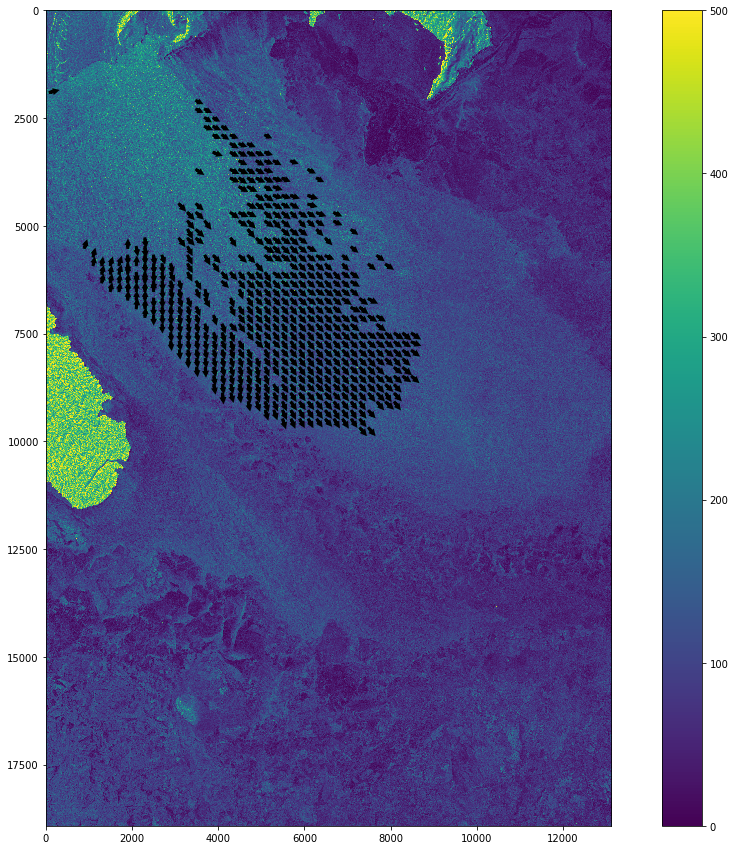

In [34]:
# Draw arrows
fig, ax = plt.subplots(1,1,figsize = (18, 15))
plt.imshow(array)
plt.colorbar()
plt.clim(0, 500)

for i in range(0, len(dF)):
    plt.arrow(dF['pix_x'][i], dF['pix_y'][i], dF['w_len'][i]*dF['u1'][i], dF['w_len'][i]*dF['u2'][i],
              head_width=dF['w_len'][i]*0.5, head_length=dF['w_len'][i]*0.5, fc='k', ec='k', linewidth = 3)
    
# plt.ylim(10000, 12000)
# plt.xlim(4000, 6000)

print("COMPLETE creating csvfile!!")

In [95]:
"wavelength=%.0f"%w

'wavelength=200'

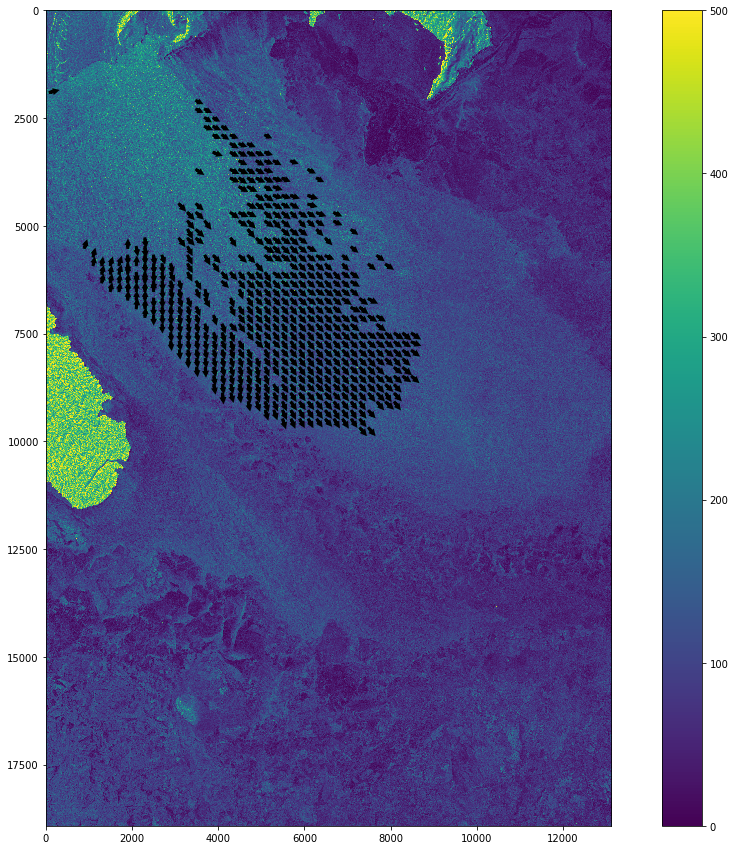

In [314]:
# Calculate the angle of northside
if mode == "DESCENDING":
    angle_n = 180 - heading
elif mode == "ASCENDING":
    angle_n = 360 - heading

if angle_n > 180:
    angle_n = -(360 - angle_n)

# Draw arrows
fig, ax = plt.subplots(1,1,figsize = (18, 15))
plt.imshow(array)
plt.colorbar()
plt.clim(0, 500)

for i in range(0, len(dF)):
    plt.arrow(dF['pix_x'][i], dF['pix_y'][i], dF['w_len'][i]*dF['u1'][i], dF['w_len'][i]*dF['u2'][i],
              head_width=dF['w_len'][i]*0.5, head_length=dF['w_len'][i]*0.5, fc='k', ec='k', linewidth = 3)
    
# plt.xlim(0, 9000)
# plt.ylim(11000, 1000)


In [222]:
# Make NC file

import linecache

def rotate_vector(u1, u2, theta):
    u2 = -u2 # change the up-down
    u1_new = u1*np.cos(theta) - u2*np.sin(theta)
    u2_new = u1*np.sin(theta) + u2*np.cos(theta)
    return u1_new, u2_new

newfile = "F:/TNB_TerraSARX/FFT/FFT_wave_{0}.nc".format(path.split("SRA_")[1][:15])
newnc = netCDF4.Dataset(newfile, mode='w')

def PrintException():
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    fn = f.f_code.co_filename
    linecache.checkcache(fn)
    line = linecache.getline(fn, lineno, f.f_globals)
    print('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(fn, lineno, line.strip(), exc_obj))

try:
    fields = [k for k in dF.keys()]
    fields = fields[:]
    fields.remove('time')
    fields.remove('lat')
    fields.remove('lon')

    dlat = 0.02
    dlon = 0.1
    lats = np.arange(-76, -73, dlat)
    lons = np.arange(160, 170, dlon)

    lat_dim = newnc.createDimension('lat', len(lats))     # latitude axis
    lon_dim = newnc.createDimension('lon', len(lons))    # longitude axis
    time_dim = newnc.createDimension('time', None) # unlimited axis (can be appended to).
    for dim in newnc.dimensions.items():
        print(dim)

    lat = newnc.createVariable('lat', np.float32, ('lat',))
    lat.units = 'degrees_north'
    lat.long_name = 'latitude'
    lon = newnc.createVariable('lon', np.float32, ('lon',))
    lon.units = 'degrees_east'
    lon.long_name = 'longitude'
    time = newnc.createVariable('time', np.float64, ('time',))
    time.units = 'seconds since 1900-01-01'
    time.long_name = 'time'

    lat[:] = lats
    lon[:] = lons

    seconds = (dF['time'][0] - dt.datetime(1900, 1, 1)).total_seconds()
    
    dF1 = dF[fields]

    time[:] = seconds
    for field in fields:
        variable = newnc.createVariable(field, np.float32,('time','lat','lon'))
        variable.long_name = field + " from TerraSAR-X"
        print(field, " dimensions: ", variable.dimensions)

        data = np.zeros([len(lats), len(lons)])
        for i in range(0, len(lats)):
            for j in range(0, len(lons)):
                idx = (abs(dF['lat']-lats[i])<dlat)&(abs(dF['lon']-lons[j])<dlon)

                if len(dF[idx]) > 1:
                    data[i, j] = dF1[idx].mean()[field]
                elif len(dF[idx]) == 1:
                    data[i, j] = dF1[idx].reset_index(drop=True)[field][0]

        if field == "u1":
            u1 = np.copy(data)
        elif field == "u2":
            u2 = np.copy(data)
        elif field == "w_len":
            w_len = np.copy(data)

        variable[:, :, :] = np.array([data])

    u1_n, u2_n = rotate_vector(u1, u2, -angle_n) * w_len
    change_vec = np.where(u1_n < 0)
    mask = np.ones(np.shape(u1_n))
    mask[change_vec] = -1
    u1_n = u1_n * mask
    u2_n = -u2_n * mask

    field = "u10"
    variable = newnc.createVariable(field, np.float32,('time','lat','lon'))
    variable.long_name = "10 metre U wave component"
    variable.units = "m s**-1"
    variable[:, :, :] = np.array([u1_n])

    field = "v10"
    variable = newnc.createVariable(field, np.float32,('time','lat','lon'))
    variable.long_name = "10 metre V wave component"
    variable.units = "m s**-1"
    variable[:, :, :] = np.array([u2_n])
    newnc.close()
    
    print("FINISH")
    
except Exception as e:
    exc_type, exc_obj, exc_tb = sys.exc_info()
    fname = os.path.split(exc_tb.tb_frame.f_code.co_filename)[1]
    print(exc_type, e, exc_tb.tb_lineno)
    PrintException()
    newnc.close()

('lat', <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 150
)
('lon', <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 100
)
('time', <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'time', size = 0
)
pix_x  dimensions:  ('time', 'lat', 'lon')
pix_y  dimensions:  ('time', 'lat', 'lon')
w_dir  dimensions:  ('time', 'lat', 'lon')
w_len  dimensions:  ('time', 'lat', 'lon')
u1  dimensions:  ('time', 'lat', 'lon')
u2  dimensions:  ('time', 'lat', 'lon')
FINISH


In [223]:
ncfile = r"F:\Iceberg_tracking\Climatology\ERA5\ERA5_monthly_windmap.nc"
nc = netCDF4.Dataset(ncfile, 'r')
# print(nc.variables)
nc.close()

In [264]:
u1_n = u1_n
dF.to_csv("F:/TNB_TerraSARX/FFT/FFT_wave_{0}.csv".format(path.split("SRA_")[1][:15]))

,pix_x,pix_y,lat,lon,w_dir,w_len,u1,u2,time
0,100,1900,-74.886800,163.522516,-14.036243,100.045945,0.970143,-0.242536,2017-05-05 09:41:49
1,3500,2100,-75.061317,164.232064,25.559965,64.718325,0.902134,0.431455,2017-05-05 09:41:49
2,3500,2300,-75.051262,164.274466,25.559965,64.718325,0.902134,0.431455,2017-05-05 09:41:49
3,3700,2300,-75.062119,164.313710,26.565051,67.082039,0.894427,0.447214,2017-05-05 09:41:49
4,3700,2500,-75.052065,164.356113,32.275644,73.424036,0.845489,0.533993,2017-05-05 09:41:49
...,...,...,...,...,...,...,...,...,...
566,6900,9500,-74.873868,166.468101,57.410271,111.179840,0.538620,0.842549,2017-05-05 09:41:49
567,7100,9500,-74.884725,166.507344,55.176615,100.717860,0.571049,0.820916,2017-05-05 09:41:49
568,7300,9500,-74.895583,166.546588,50.115522,96.180961,0.641242,0.767339,2017-05-05 09:41:49
569,7300,9700,-74.885528,166.588991,50.194429,105.630426,0.640184,0.768221,2017-05-05 09:41:49


In [68]:
# Read and make ERA5 csv file
def get_daily_ERA5(ncfile, bounding_box, time_ib, csvname):
# ncfile: input monthly ERA5 file (ncfile)
# field: input variable ('sst', 't2m', 'u10', 'v10')
# bounding_box: processed area (Ross Sea - Amundsen Sea)
# latlon_ib: geocoordinates of the iceberg (lat, lon)
# time_ib: date of the iceberg (datetime format)

    nc = netCDF4.Dataset(ncfile, 'r')
    keys = nc.variables.keys()
    fields = ['u10', 'v10', 't2m', 'sp']
    
    lat = np.array(nc.variables['latitude'])
    lon = np.array(nc.variables['longitude'])

    data_oc = {}
    
    seconds = np.array(nc.variables['time']).astype(float) * 3600
    
    ind = 0
    timegap = 3600 * 24 * 30 # 1 day
    for i in range(0, len(seconds)):
        time_era = dt.datetime(1900, 1, 1) + dt.timedelta(seconds = seconds[i])
        if (abs(time_ib - time_era).days < timegap) and (time_ib > time_era):
            timegap = abs(time_ib - time_era).total_seconds()
            ind = i
    
    if ind >= 0:     
        
        lat_ext = np.where((lat > bounding_box[1]) & (lat < bounding_box[3]))[0]
        lon_ext = np.where((lon >= bounding_box[0]) & (lon < bounding_box[2]))[0]    
        
        lons, lats = np.meshgrid(lon[lon_ext], lat[lat_ext])
        dF = pd.DataFrame({'lat': lats.flatten(), 'lon': lons.flatten()})
        
        for field in fields:
            data = np.array(nc.variables[field][ind])
            data = data[lat_ext, :][:, lon_ext]
            
            scale = len(data[data == -32767])/len(data[data >= -32767])
            
            if scale < 0.75:
                dF[field] = data.flatten() 
                
            print(field)
        
        dF.to_csv(csvname)
        print("ERA5 data was converted to {0}".format(csvname))
        
## MAIN
ncfile = r"F:\TNB_TerraSARX\ERA5\ERA5_SH_hourly.nc"
bounding_box = [160, -77, 175, -73]
time_ib = dt.datetime(2017, 5, 5, 15, 55, 30)
time_ib = dt.datetime(2017, 5, 5, 9, 41, 49)
csvname = "F:/TNB_TerraSARX/ERA5/ERA5_{0}.csv".format(time_ib.strftime("%Y%m%dT%H%M%S"))
get_daily_ERA5(ncfile, bounding_box, time_ib, csvname)

u10
v10
t2m
sp
ERA5 data was converted to F:/TNB_TerraSARX/ERA5/ERA5_20170505T094149.csv


In [56]:
nc = netCDF4.Dataset(ncfile, 'r')
nc.variables

OrderedDict([('longitude',
              <class 'netCDF4._netCDF4.Variable'>
              float32 longitude(longitude)
                  units: degrees_east
                  long_name: longitude
              unlimited dimensions: 
              current shape = (1440,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('latitude',
              <class 'netCDF4._netCDF4.Variable'>
              float32 latitude(latitude)
                  units: degrees_north
                  long_name: latitude
              unlimited dimensions: 
              current shape = (361,)
              filling on, default _FillValue of 9.969209968386869e+36 used),
             ('time',
              <class 'netCDF4._netCDF4.Variable'>
              int32 time(time)
                  units: hours since 1900-01-01 00:00:00.0
                  long_name: time
                  calendar: gregorian
              unlimited dimensions: 
              current shape = (1224

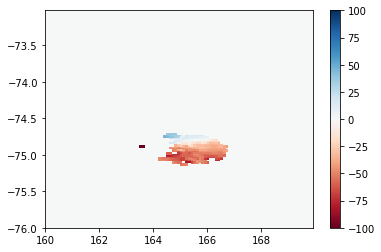

In [257]:
xx, yy = np.meshgrid(lons, lats)
plt.pcolor(xx, yy, u2_n, cmap = "RdBu")
plt.colorbar()
plt.clim(-100,100)

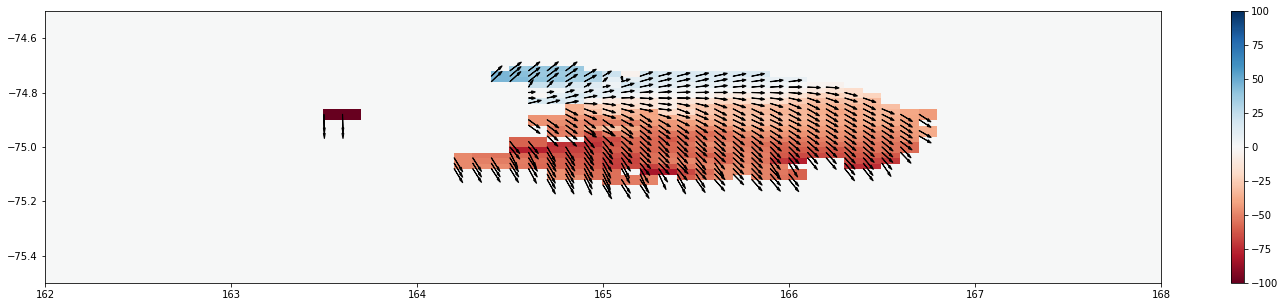

In [263]:
# xx, yy = np.meshgrid(lon, lat)
fig, ax = plt.subplots(1,1,figsize = (25,5))
plt.pcolor(xx, yy, u2_n, cmap = "RdBu")
plt.clim(-100,100)
for i in range(0, np.shape(u1_n)[0]):
    for j in range(0, np.shape(u1_n)[1]):
        if w_len[i,j] > 0:
            plt.arrow(xx[i,j], yy[i,j], u1_n[i,j]/w_len[i,j]*0.05, u2_n[i,j]/w_len[i,j]*0.05,
                      head_width=0.01, head_length=0.02, fc='k', ec='k', linewidth = 1)
plt.colorbar()
plt.xlim(162, 168)
plt.ylim(-75.5, -74.5)
plt.show()

In [186]:
np.shape(yy)

(150, 100)

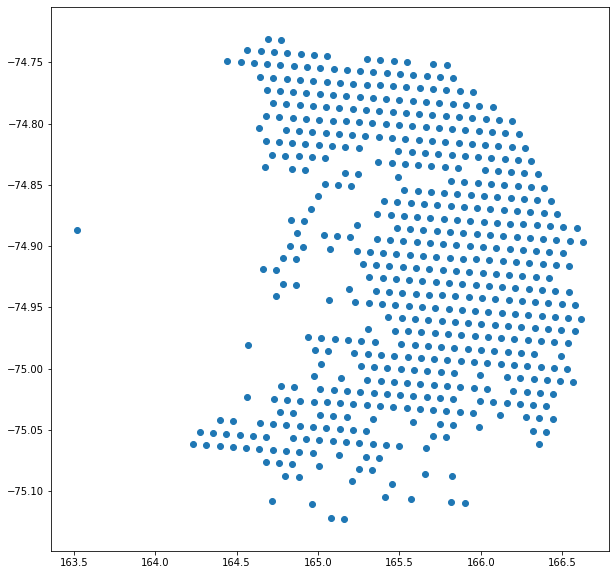

In [21]:
fig, ax = plt.subplots(1,1,figsize = (10, 10))
plt.scatter(dF['lon'], dF['lat'])

In [28]:
from netCDF4 import Dataset

## Function to read ERA5 file
def get_ERA5(ncfile, bounding_box, dftrx, lat_ib = None, lon_ib = None):
# ncfile: input monthly ERA5 file (ncfile)
# field: input variable ('sst', 't2m', 'u10', 'v10')
# bounding_box: processed area (Ross Sea - Amundsen Sea)
# latlon_ib: geocoordinates of the iceberg (lat, lon)
# time_ib: date of the iceberg (datetime format)
    import time
    t0 = time.time()
    
    nc = Dataset(ncfile, 'r')
    keys = nc.variables.keys()
    fields = [k for k in keys]
    fields = fields[3:]
    
    lat = np.arange(-77)
    lon = np.array(nc.variables['longitude'])
    
    lat_ext = np.where((lat > bounding_box[1]) & (lat < bounding_box[3]))[0]
    lon_ext = np.where((lon >= bounding_box[0]) & (lon < bounding_box[2]))[0]    

    data_oc = {}
    
    time_era = []
    seconds = np.array(nc.variables['time']).astype(float) * 3600
    
#     k = 0 # Index for dftrx
#     time_trx = dftrx['date'][k]
#     lat_ib = dftrx['lat'][k]
#     lon_ib = dftrx['lon'][k]
    xx, yy = np.meshgrid(lon[lon_ext], lat[lat_ext])
    lat_ind = np.argmin((xx-lon_ib)**2 + (yy-lat_ib)**2, axis = 0)[0]
    lon_ind = np.argmin((xx-lon_ib)**2 + (yy-lat_ib)**2, axis = 1)[0]

    for i in range(0, len(seconds)):
        t = dt.datetime(1900, 1, 1) + dt.timedelta(seconds = seconds[i])
        
#         if dftrx['date'][k] <= t:
#             k += 1
#             k = min(k, len(dftsx)-1)
#             lat_ib = dftrx['lat'][k]
#             lon_ib = dftrx['lon'][k]
#             lat_ind = np.argmin((xx-lon_ib)**2 + (yy-lat_ib)**2, axis = 0)[0]
#             lon_ind = np.argmin((xx-lon_ib)**2 + (yy-lat_ib)**2, axis = 1)[0]        
        
        time_era.append(t)     
        for field in fields:
            variable = newnc.createVariable(field, np.float32,('time','lat','lon'))
            variable.units = nc.variables[field].units
            variable.long_name = nc.variables[field].long_name
            print(field, " dimensions: ", variable.dimensions)
            if i == 0:
                data_oc[field] = []
            data = np.array(nc.variables[field][i])
            data = data[lat_ext, :][:, lon_ext]
            
            scale = len(data[data == -32767])/len(data[data >= -32767])
            
            if scale > 0.75:
                data_oc[field].append(data[int(lat_ind/2), int(lon_ind/2)])
            else:
                data_oc[field].append(data[lat_ind, lon_ind])
        
        if i%50 == 0:
            t1 = time.time()
            print("... {0} / {1} ({2} s)".format(i, len(seconds), round(t1-t0, 3)))
        
    lat_oc = lat[lat_ind]
    lon_oc = lon[lon_ind]
    displace = ((lat_oc - lat_ib)**2 + (lon_oc - lon_ib)**2)**0.5
    
    df = pd.DataFrame(data_oc)
    df['time'] = time_era
    df['lat'] = lat_oc
    df['lon'] = lon_oc
    df['displace'] = displace

    return df


ncfile = r"F:\TNB_TerraSARX\ERA5\ERA5_SH_hourly.nc"
nc = Dataset(ncfile, 'r')
lat = nc.variables['latitude'][:]
lon = nc.variables['longitude'][:]

# bounding_box = [-180, -90, 180, 0]
# df = get_ERA5(ncfile, bounding_box, dftsx, lat_tnb, lon_tnb)

# print("==== FINISH =====")

In [29]:
lon

masked_array(data=[-180.  , -179.75, -179.5 , ...,  179.25,  179.5 ,
                    179.75],
             mask=False,
       fill_value=1e+20,
            dtype=float32)